In [1]:
## import packages
from datetime import datetime
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import hail as hl

In [3]:
# set up hail
hl.init(default_reference = "GRCh38")

/opt/conda/lib/python3.10/site-packages/hail/context.py:352: UserWarning:

Using hl.init with a default_reference argument is deprecated. To set a default reference genome after initializing hail, call `hl.default_reference` with an argument to set the default reference genome.

/opt/conda/lib/python3.10/site-packages/hailtop/aiocloud/aiogoogle/user_config.py:43: UserWarning:

Reading spark-defaults.conf to determine GCS requester pays configuration. This is deprecated. Please use `hailctl config set gcs_requester_pays/project` and `hailctl config set gcs_requester_pays/buckets`.

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
Running on Apache Spark version 3.3.0
SparkUI available at http://all-of-us-11150-m.us-central1-c.c.terra-vpc-sc-fd39b54c.internal:46399
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.130.post1-c69cd67afb8b
LOGGING: writing

In [4]:
bucket = os.getenv('WORKSPACE_BUCKET')

# Array

In [6]:
mt_array = hl.read_matrix_table(f"{bucket}/ArrayData/Array_GT_QCed.mt")
mt_array = mt_array.key_rows_by("locus")

In [7]:
## read Sample_quant 
Sample_quant = hl.import_table(f"{bucket}/Pheno/quant_all.tsv", 
                         missing='',
                        impute=True,
                        types = {"person_id": "str"})
Sample_quant = Sample_quant.key_by("person_id")
mt_array_quant = mt_array.semi_join_cols(Sample_quant)
mt_array_quant = mt_array_quant.annotate_cols(**Sample_quant[mt_array_quant.s])


#### read Sample_binary
Sample_binary = hl.import_table(f"{bucket}/Pheno/binary_all.tsv", 
                         missing='',
                        impute=True,
                        types = {"person_id": "str"})
Sample_binary = Sample_binary.key_by("person_id")
mt_array_binary = mt_array.semi_join_cols(Sample_binary)
mt_array_binary = mt_array_binary.annotate_cols(**Sample_binary[mt_array_binary.s])

2024-11-22 05:16:09.889 Hail: INFO: Reading table to impute column types 1) / 1]
2024-11-22 05:16:14.822 Hail: INFO: Loading <StructExpression of type struct{person_id: str, Age: int32, is_sex_Male: int32, is_sex_Female: int32, is_White: int32, is_Black_or_African_American: int32, is_Native_Hawaiian_or_Other_Pacific_Islander: int32, is_Asian: int32, is_Middle_Eastern_or_North_African: int32, is_gender_Male: int32, is_gender_Female: int32, is_Hispanic: int32, is_anc_pred_eur: int32, is_anc_pred_amr: int32, is_anc_pred_afr: int32, is_anc_pred_sas: int32, is_anc_pred_eas: int32, is_anc_pred_mid: int32, PC1: float64, PC2: float64, PC3: float64, PC4: float64, PC5: float64, PC6: float64, PC7: float64, PC8: float64, PC9: float64, PC10: float64, PC11: float64, PC12: float64, PC13: float64, PC14: float64, PC15: float64, PC16: float64, BMI: float64, Height: float64, DBP: float64, SBP: float64, HbA1c: float64, leukocyte: float64, Lymphocyte: float64, RBC: float64, Neutrophil: float64, Hemoglobin_

## Create ancestry specific MT

In [8]:
mt_array_quant_eur = mt_array_quant.filter_cols(mt_array_quant.is_anc_pred_eur == 1)
mt_array_quant_amr = mt_array_quant.filter_cols(mt_array_quant.is_anc_pred_amr == 1)
mt_array_quant_afr = mt_array_quant.filter_cols(mt_array_quant.is_anc_pred_afr == 1)

mt_array_binary_eur = mt_array_binary.filter_cols(mt_array_binary.is_anc_pred_eur == 1)
mt_array_binary_amr = mt_array_binary.filter_cols(mt_array_binary.is_anc_pred_amr == 1)
mt_array_binary_afr = mt_array_binary.filter_cols(mt_array_binary.is_anc_pred_afr == 1)

## Annotate rows with allele frequency

In [9]:
mt_array_quant_eur = mt_array_quant_eur.annotate_rows(allele_freq = hl.agg.mean(mt_array_quant_eur.GT) / 2)
mt_array_quant_amr = mt_array_quant_amr.annotate_rows(allele_freq = hl.agg.mean(mt_array_quant_amr.GT) / 2)
mt_array_quant_afr = mt_array_quant_afr.annotate_rows(allele_freq = hl.agg.mean(mt_array_quant_afr.GT) / 2)

mt_array_binary_eur = mt_array_binary_eur.annotate_rows(allele_freq = hl.agg.mean(mt_array_binary_eur.GT) / 2)
mt_array_binary_amr = mt_array_binary_amr.annotate_rows(allele_freq = hl.agg.mean(mt_array_binary_amr.GT) / 2)
mt_array_binary_afr = mt_array_binary_afr.annotate_rows(allele_freq = hl.agg.mean(mt_array_binary_afr.GT) / 2)

In [10]:
mt_array_quant_eur.rows().write(f"{bucket}/AF/array_quant_eur.ht", overwrite=True)
mt_array_quant_amr.rows().write(f"{bucket}/AF/array_quant_amr.ht", overwrite=True)
mt_array_quant_afr.rows().write(f"{bucket}/AF/array_quant_afr.ht", overwrite=True)

mt_array_binary_eur.rows().write(f"{bucket}/AF/array_binary_eur.ht", overwrite=True)
mt_array_binary_amr.rows().write(f"{bucket}/AF/array_binary_amr.ht", overwrite=True)
mt_array_binary_afr.rows().write(f"{bucket}/AF/array_binary_afr.ht", overwrite=True)

2024-11-22 05:24:08.237 Hail: INFO: wrote table with 975876 rows in 74 partitions to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/AF/array_quant_eur.ht
2024-11-22 05:28:32.402 Hail: INFO: wrote table with 975876 rows in 74 partitions to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/AF/array_quant_amr.ht
2024-11-22 05:33:13.343 Hail: INFO: wrote table with 975876 rows in 74 partitions to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/AF/array_quant_afr.ht
2024-11-22 05:38:27.949 Hail: INFO: wrote table with 975876 rows in 74 partitions to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/AF/array_binary_eur.ht
2024-11-22 05:42:55.332 Hail: INFO: wrote table with 975876 rows in 74 partitions to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/AF/array_binary_amr.ht
2024-11-22 05:47:33.014 Hail: INFO: wrote table with 975876 rows in 74 partitions to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/AF/array_binary_afr.ht


## Subset to clumped variants

### quant

In [39]:
array_quant_eur = hl.read_table(f"{bucket}/AF/array_quant_eur.ht")
array_quant_amr = hl.read_table(f"{bucket}/AF/array_quant_amr.ht")
array_quant_afr = hl.read_table(f"{bucket}/AF/array_quant_afr.ht")

In [40]:
# Print row counts
print(f"Number of variants in array_quant_eur: {array_quant_eur.count()}")
print(f"Number of variants in array_quant_amr: {array_quant_amr.count()}")
print(f"Number of variants in array_quant_afr: {array_quant_afr.count()}")

Number of variants in array_quant_eur: 975876
Number of variants in array_quant_amr: 975876
Number of variants in array_quant_afr: 975876


### binary

In [41]:
array_binary_eur = hl.read_table(f"{bucket}/AF/array_binary_eur.ht")
array_binary_amr = hl.read_table(f"{bucket}/AF/array_binary_amr.ht")
array_binary_afr = hl.read_table(f"{bucket}/AF/array_binary_afr.ht")

In [42]:
# Print row counts
print(f"Number of variants in array_binary_eur: {array_binary_eur.count()}")
print(f"Number of variants in array_binary_amr: {array_binary_amr.count()}")
print(f"Number of variants in array_binary_afr: {array_binary_afr.count()}")

Number of variants in array_binary_eur: 975876
Number of variants in array_binary_amr: 975876
Number of variants in array_binary_afr: 975876


### Subset and plot together

In [43]:
# Define the phenotypes and ancestries for both quantitative and binary datasets
quantitative_phenotypes = ["Height", "DBP", "HDL", "TC", "RBC", "leukocyte"]
binary_phenotypes = ["Asthma", "T2D", "Colorectal_Cancer", "Breast_Cancer"]
ancestries = ["eur", "amr", "afr"]

# Initialize a dictionary to store allele frequencies
allele_frequencies = {}

# Process quantitative phenotypes
for pheno in quantitative_phenotypes:
    # Read the sumstats for the current phenotype (quantitative)
    sumstats = hl.read_table(f"{bucket}/hail_checkpoints/{pheno}_sumstats_checkpoint.ht")
    
    # Process each ancestry for the quantitative phenotypes
    for anc in ancestries:
        # Dynamically subset the MatrixTable based on ancestry
        if anc == "eur":
            subset_array = array_quant_eur.semi_join(sumstats)
        elif anc == "amr":
            subset_array = array_quant_amr.semi_join(sumstats)
        elif anc == "afr":
            subset_array = array_quant_afr.semi_join(sumstats)
        
        # Collect allele frequencies into a Python list
        af_list = subset_array.allele_freq.collect()
        
        # Store the allele frequencies in the dictionary
        key = f"{pheno}_{anc}"
        allele_frequencies[key] = af_list

# Process binary phenotypes
for pheno in binary_phenotypes:
    # Read the sumstats for the current phenotype (binary)
    sumstats = hl.read_table(f"{bucket}/hail_checkpoints/{pheno}_sumstats_checkpoint.ht")
    
    # Process each ancestry for the binary phenotypes
    for anc in ancestries:
        # Dynamically subset the MatrixTable based on ancestry
        if anc == "eur":
            subset_array = array_binary_eur.semi_join(sumstats)
        elif anc == "amr":
            subset_array = array_binary_amr.semi_join(sumstats)
        elif anc == "afr":
            subset_array = array_binary_afr.semi_join(sumstats)
        
        # Collect allele frequencies into a Python list
        af_list = subset_array.allele_freq.collect()
        
        # Store the allele frequencies in the dictionary
        key = f"{pheno}_{anc}"
        allele_frequencies[key] = af_list

2025-01-12 03:45:12.670 Hail: INFO: wrote table with 262399 rows in 1 partition to /tmp/__iruid_86678-G0mTV6Djg06tR6Ivc6b5SV
2025-01-12 03:45:16.357 Hail: INFO: wrote table with 262399 rows in 1 partition to /tmp/__iruid_87610-vg2kwABW1oaEWnQOdo7TiD
2025-01-12 03:45:19.910 Hail: INFO: wrote table with 262399 rows in 1 partition to /tmp/__iruid_88542-IQaQQMCMsLBukDTLpxqVfa
2025-01-12 03:45:23.910 Hail: INFO: wrote table with 261858 rows in 1 partition to /tmp/__iruid_89474-RH6RkTeSCUAj6ROALXKUC5
2025-01-12 03:45:27.325 Hail: INFO: wrote table with 261858 rows in 1 partition to /tmp/__iruid_90406-Dn7psN3ioKOkBcg692BPbL
2025-01-12 03:45:30.889 Hail: INFO: wrote table with 261858 rows in 1 partition to /tmp/__iruid_91338-PhLN6vEkzbF9wZfVdvHZLi
2025-01-12 03:45:34.902 Hail: INFO: wrote table with 261583 rows in 1 partition to /tmp/__iruid_92270-W1oWg2186auLQ2wRDTLHaf
2025-01-12 03:45:39.034 Hail: INFO: wrote table with 261583 rows in 1 partition to /tmp/__iruid_93202-tGBQb8TmsIi4LaSJRJl4Km


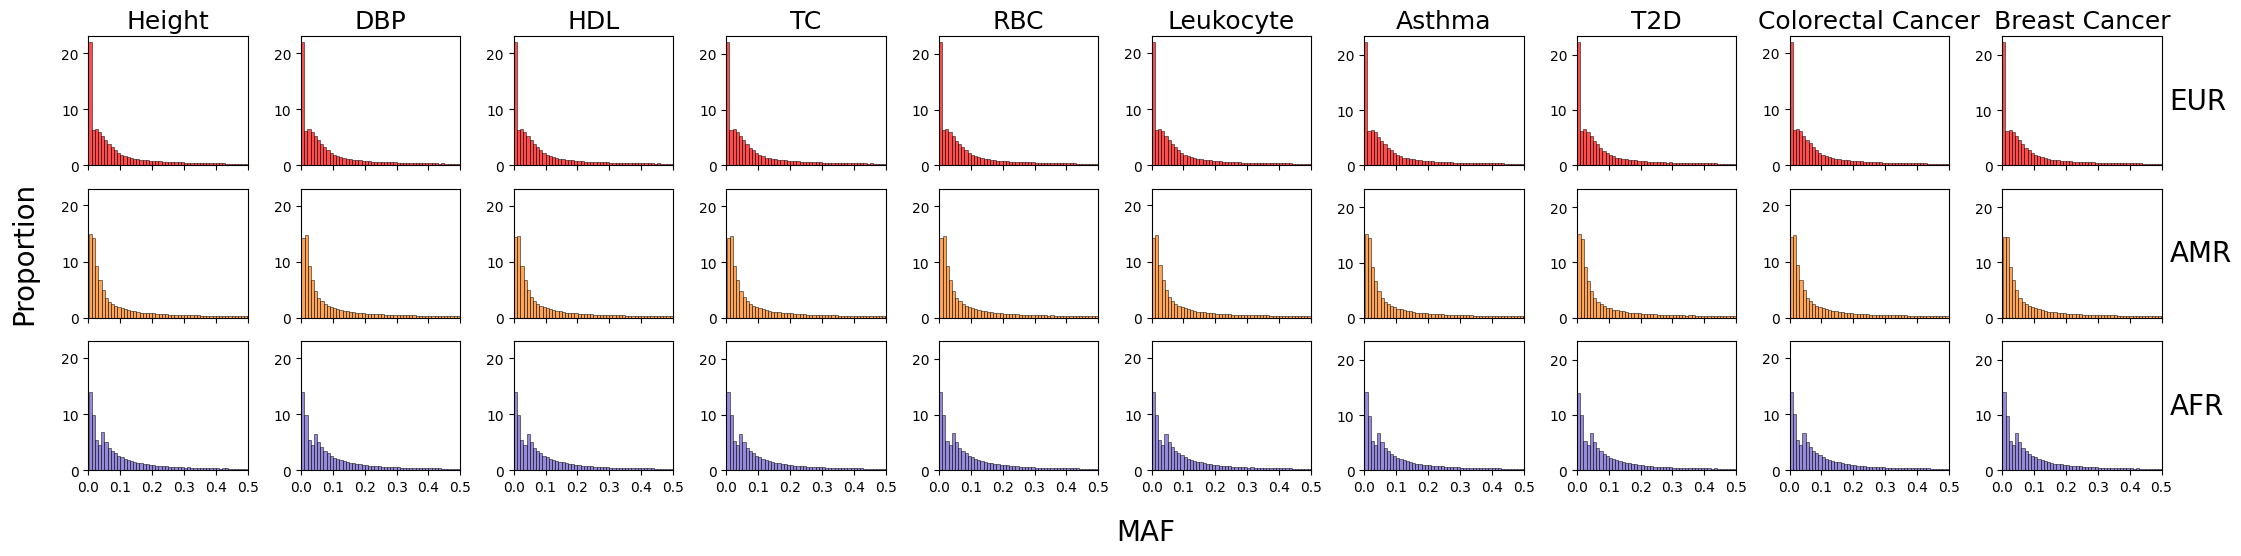

In [44]:
# Rename some phenotypes
phenotype_mapping = {
    'leukocyte': 'Leukocyte',  
    'Colorectal_Cancer': 'Colorectal Cancer',  
    'Breast_Cancer': 'Breast Cancer',
}

# Create the figure and subplots with much wider and shorter dimensions
fig, axes = plt.subplots(len(ancestries), len(quantitative_phenotypes) + len(binary_phenotypes), 
                         figsize=(len(quantitative_phenotypes) + len(binary_phenotypes) * 4, len(ancestries) * 2),  # Wider, shorter
                         sharex=True, sharey='col')

# Combine the two phenotype lists
all_phenotypes = quantitative_phenotypes + binary_phenotypes

# Loop through ancestries and phenotypes to plot histograms
for j, anc in enumerate(ancestries):  # Iterate over ancestries in rows
    for i, pheno in enumerate(all_phenotypes):  # Iterate over phenotypes in columns
        key = f"{pheno}_{anc}"
        data = allele_frequencies.get(key, [])
        
        # Plot the histogram with density (proportions) instead of raw count
        axes[j, i].hist(
            data, bins=100, alpha=0.7, edgecolor='black', linewidth=0.5,
            color=['red', '#ff7f0e', 'slateblue'][j], density=True  # Normalize to get proportions
        )
        axes[j, i].set_xlim(0, 0.5)  # Set the limit for the MAF range
        
        # Set titles and labels
        if j == 0:  # Only on the first row
            # Use the mapped descriptive name for the phenotype if available
            axes[j, i].set_title(phenotype_mapping.get(pheno, pheno), fontsize=18)  # Set phenotype title with the mapped label
        
        # Place ancestry label on the right side of each column
        if i == len(all_phenotypes) - 1:
            axes[j, i].text(1.05, 0.5, anc.upper(), ha='left', va='center', fontsize=20, transform=axes[j, i].transAxes)

        # Set x-axis ticks
        axes[j, i].set_xticks([x / 10 for x in range(6)])  # Create ticks from 0 to 0.5 with step 0.1
        axes[j, i].set_xticklabels([f'{x/10:.1f}' for x in range(6)])  # Format ticks as 0.0, 0.1, ..., 0.5

# Add overall x-axis label
fig.supxlabel("MAF", fontsize=20)

# Add one shared y-axis label for the entire figure (and hide all individual y-axis labels)
fig.text(-0.01, 0.5, "Proportion", ha='center', va='center', fontsize=20, rotation=90)

# Remove all individual y-axis labels
for ax in axes.flatten():
    ax.set_ylabel('')  # Hide individual y-axis labels

# Adjust layout to ensure proper spacing
plt.tight_layout(rect=[0, 0, 1, 0.93])

# Show the plot
plt.show()

# WGS

In [23]:
mt_wgs = hl.read_matrix_table(f"{bucket}/WGSData/WGS_GT_QCed_clumpedUnion.mt")
mt_wgs = mt_wgs.key_rows_by("locus")

In [28]:
## read Sample_quant 
Sample_quant = hl.import_table(f"{bucket}/Pheno/quant_all.tsv", 
                         missing='',
                        impute=True,
                        types = {"person_id": "str"})
Sample_quant = Sample_quant.key_by("person_id")
mt_wgs_quant = mt_wgs.semi_join_cols(Sample_quant)
mt_wgs_quant = mt_wgs_quant.annotate_cols(**Sample_quant[mt_wgs_quant.s])


#### read Sample_binary
Sample_binary = hl.import_table(f"{bucket}/Pheno/binary_all.tsv", 
                         missing='',
                        impute=True,
                        types = {"person_id": "str"})
Sample_binary = Sample_binary.key_by("person_id")
mt_wgs_binary = mt_wgs.semi_join_cols(Sample_binary)
mt_wgs_binary = mt_wgs_binary.annotate_cols(**Sample_binary[mt_wgs_binary.s])

2025-01-06 03:38:32.644 Hail: INFO: Reading table to impute column types
2025-01-06 03:38:36.961 Hail: INFO: Loading <StructExpression of type struct{person_id: str, Age: int32, is_sex_Male: int32, is_sex_Female: int32, is_White: int32, is_Black_or_African_American: int32, is_Native_Hawaiian_or_Other_Pacific_Islander: int32, is_Asian: int32, is_Middle_Eastern_or_North_African: int32, is_gender_Male: int32, is_gender_Female: int32, is_Hispanic: int32, is_anc_pred_eur: int32, is_anc_pred_amr: int32, is_anc_pred_afr: int32, is_anc_pred_sas: int32, is_anc_pred_eas: int32, is_anc_pred_mid: int32, PC1: float64, PC2: float64, PC3: float64, PC4: float64, PC5: float64, PC6: float64, PC7: float64, PC8: float64, PC9: float64, PC10: float64, PC11: float64, PC12: float64, PC13: float64, PC14: float64, PC15: float64, PC16: float64, BMI: float64, Height: float64, DBP: float64, SBP: float64, HbA1c: float64, leukocyte: float64, Lymphocyte: float64, RBC: float64, Neutrophil: float64, Hemoglobin_concentr

## Create ancestry specific MT

In [26]:
mt_wgs_quant_eur = mt_wgs_quant.filter_cols(mt_wgs_quant.is_anc_pred_eur == 1)
mt_wgs_quant_amr = mt_wgs_quant.filter_cols(mt_wgs_quant.is_anc_pred_amr == 1)
mt_wgs_quant_afr = mt_wgs_quant.filter_cols(mt_wgs_quant.is_anc_pred_afr == 1)

mt_wgs_binary_eur = mt_wgs_binary.filter_cols(mt_wgs_binary.is_anc_pred_eur == 1)
mt_wgs_binary_amr = mt_wgs_binary.filter_cols(mt_wgs_binary.is_anc_pred_amr == 1)
mt_wgs_binary_afr = mt_wgs_binary.filter_cols(mt_wgs_binary.is_anc_pred_afr == 1)

## Annotate rows with allele frequency

In [26]:
mt_wgs_quant_eur = mt_wgs_quant_eur.annotate_rows(allele_freq = hl.agg.mean(mt_wgs_quant_eur.GT) / 2)
mt_wgs_quant_amr = mt_wgs_quant_amr.annotate_rows(allele_freq = hl.agg.mean(mt_wgs_quant_amr.GT) / 2)
mt_wgs_quant_afr = mt_wgs_quant_afr.annotate_rows(allele_freq = hl.agg.mean(mt_wgs_quant_afr.GT) / 2)

mt_wgs_binary_eur = mt_wgs_binary_eur.annotate_rows(allele_freq = hl.agg.mean(mt_wgs_binary_eur.GT) / 2)
mt_wgs_binary_amr = mt_wgs_binary_amr.annotate_rows(allele_freq = hl.agg.mean(mt_wgs_binary_amr.GT) / 2)
mt_wgs_binary_afr = mt_wgs_binary_afr.annotate_rows(allele_freq = hl.agg.mean(mt_wgs_binary_afr.GT) / 2)

In [ ]:
mt_wgs_quant_eur.rows().write(f"{bucket}/AF/wgs_quant_eur.ht", overwrite=True)
mt_wgs_quant_amr.rows().write(f"{bucket}/AF/wgs_quant_amr.ht", overwrite=True)
mt_wgs_quant_afr.rows().write(f"{bucket}/AF/wgs_quant_afr.ht", overwrite=True)

mt_wgs_binary_eur.rows().write(f"{bucket}/AF/wgs_binary_eur.ht", overwrite=True)
mt_wgs_binary_amr.rows().write(f"{bucket}/AF/wgs_binary_amr.ht", overwrite=True)
mt_wgs_binary_afr.rows().write(f"{bucket}/AF/wgs_binary_afr.ht", overwrite=True)

2024-11-22 06:44:40.119 Hail: INFO: wrote table with 2156896 rows in 140126 partitions to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/AF/wgs_quant_eur.ht
2024-11-22 07:33:01.523 Hail: INFO: wrote table with 2156896 rows in 140126 partitions to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/AF/wgs_quant_amr.ht
2024-11-22 08:17:59.978 Hail: INFO: wrote table with 2156896 rows in 140126 partitions to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/AF/wgs_quant_afr.ht
2024-11-22 09:02:56.487 Hail: INFO: wrote table with 2156896 rows in 140126 partitions to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/AF/wgs_binary_eur.ht
2024-11-22 09:47:12.400 Hail: INFO: wrote table with 2156896 rows in 140126 partitions to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/AF/wgs_binary_amr.ht


## Subset to clumped variants

### quant

In [27]:
wgs_quant_eur = hl.read_table(f"{bucket}/AF/wgs_quant_eur.ht")
wgs_quant_amr = hl.read_table(f"{bucket}/AF/wgs_quant_amr.ht")
wgs_quant_afr = hl.read_table(f"{bucket}/AF/wgs_quant_afr.ht")

In [28]:
# Print row counts
print(f"Number of variants in wgs_eur: {wgs_quant_eur.count()}")
print(f"Number of variants in wgs_amr: {wgs_quant_amr.count()}")
print(f"Number of variants in wgs_afr: {wgs_quant_afr.count()}")

Number of variants in wgs_eur: 2156896
Number of variants in wgs_amr: 2156896
Number of variants in wgs_afr: 2156896


### binary

In [29]:
wgs_binary_eur = hl.read_table(f"{bucket}/AF/wgs_binary_eur.ht")
wgs_binary_amr = hl.read_table(f"{bucket}/AF/wgs_binary_amr.ht")
wgs_binary_afr = hl.read_table(f"{bucket}/AF/wgs_binary_afr.ht")

In [30]:
# Print row counts
print(f"Number of variants in wgs_eur: {wgs_binary_eur.count()}")
print(f"Number of variants in wgs_amr: {wgs_binary_amr.count()}")
print(f"Number of variants in wgs_afr: {wgs_binary_afr.count()}")

Number of variants in wgs_eur: 2156896
Number of variants in wgs_amr: 2156896
Number of variants in wgs_afr: 2156896


### Subset and plot together

In [31]:
# estimated run time: 3hr
# Define the phenotypes and ancestries for both quantitative and binary datasets
quantitative_phenotypes = ["Height", "DBP", "HDL", "TC", "RBC", "leukocyte"]
binary_phenotypes = ["Asthma", "T2D", "Colorectal_Cancer", "Breast_Cancer"]
ancestries = ["eur", "amr", "afr"]

# Initialize a dictionary to store allele frequencies
allele_frequencies = {}

# Process quantitative phenotypes
for pheno in quantitative_phenotypes:
    # Read the sumstats for the current phenotype (quantitative)
    sumstats = hl.read_table(f"{bucket}/hail_checkpoints/{pheno}_sumstats_checkpoint2.ht")
    
    # Process each ancestry for the quantitative phenotypes
    for anc in ancestries:
        # Dynamically subset the MatrixTable based on ancestry
        if anc == "eur":
            subset_wgs = wgs_quant_eur.semi_join(sumstats)
        elif anc == "amr":
            subset_wgs = wgs_quant_amr.semi_join(sumstats)
        elif anc == "afr":
            subset_wgs = wgs_quant_afr.semi_join(sumstats)
        
        # Collect allele frequencies into a Python list
        af_list = subset_wgs.allele_freq.collect()
        
        # Store the allele frequencies in the dictionary
        key = f"{pheno}_{anc}"
        allele_frequencies[key] = af_list

# Process binary phenotypes
for pheno in binary_phenotypes:
    # Read the sumstats for the current phenotype (binary)
    sumstats = hl.read_table(f"{bucket}/hail_checkpoints/{pheno}_sumstats_checkpoint2.ht")
    
    # Process each ancestry for the binary phenotypes
    for anc in ancestries:
        # Dynamically subset the MatrixTable based on ancestry
        if anc == "eur":
            subset_wgs = wgs_binary_eur.semi_join(sumstats)
        elif anc == "amr":
            subset_wgs = wgs_binary_amr.semi_join(sumstats)
        elif anc == "afr":
            subset_wgs = wgs_binary_afr.semi_join(sumstats)
        
        # Collect allele frequencies into a Python list
        af_list = subset_wgs.allele_freq.collect()
        
        # Store the allele frequencies in the dictionary
        key = f"{pheno}_{anc}"
        allele_frequencies[key] = af_list

2025-01-12 02:39:40.521 Hail: INFO: wrote table with 468717 rows in 1 partition to /tmp/__iruid_58706-dquXuonEol9fjuUwfBXeaR
2025-01-12 02:43:20.797 Hail: INFO: wrote table with 468717 rows in 1 partition to /tmp/__iruid_59638-SH1eYLqxqyiF6ExLtMxeqn
2025-01-12 02:44:54.636 Hail: INFO: wrote table with 468717 rows in 1 partition to /tmp/__iruid_60570-9moCj0dMjVL7Adwf7hOwWi
2025-01-12 02:46:27.661 Hail: INFO: wrote table with 466453 rows in 1 partition to /tmp/__iruid_61502-LG6jE3k7qPY2FJgBbIuhJT
2025-01-12 02:47:56.922 Hail: INFO: wrote table with 466453 rows in 1 partition to /tmp/__iruid_62434-btuhhrejtAFNAJsTKNXfnN
2025-01-12 02:49:23.988 Hail: INFO: wrote table with 466453 rows in 1 partition to /tmp/__iruid_63366-9PeZMU1pVyh06Uoatm8X0D
2025-01-12 02:50:51.762 Hail: INFO: wrote table with 465726 rows in 1 partition to /tmp/__iruid_64298-SwY36c5n0yyvvP5A3gI2fM
2025-01-12 02:52:07.928 Hail: INFO: wrote table with 465726 rows in 1 partition to /tmp/__iruid_65230-MXhopZt4nbDHUti0qvrgx4


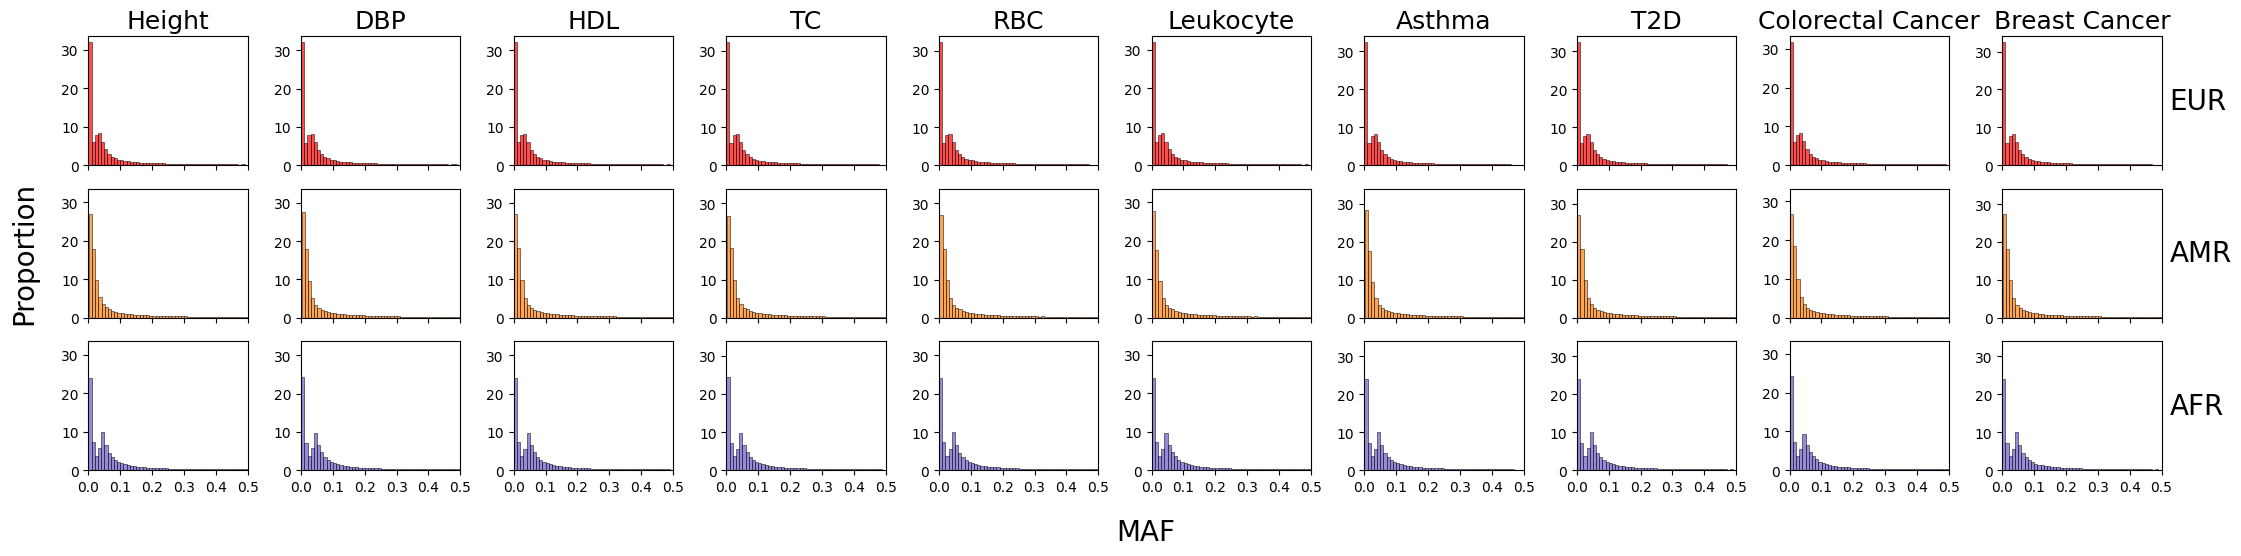

In [38]:
# Rename some phenotypes
phenotype_mapping = {
    'leukocyte': 'Leukocyte',  
    'Colorectal_Cancer': 'Colorectal Cancer',  
    'Breast_Cancer': 'Breast Cancer',
}

# Create the figure and subplots with much wider and shorter dimensions
fig, axes = plt.subplots(len(ancestries), len(quantitative_phenotypes) + len(binary_phenotypes), 
                         figsize=(len(quantitative_phenotypes) + len(binary_phenotypes) * 4, len(ancestries) * 2),  # Wider, shorter
                         sharex=True, sharey='col')

# Combine the two phenotype lists
all_phenotypes = quantitative_phenotypes + binary_phenotypes

# Loop through ancestries and phenotypes to plot histograms
for j, anc in enumerate(ancestries):  # Iterate over ancestries in rows
    for i, pheno in enumerate(all_phenotypes):  # Iterate over phenotypes in columns
        key = f"{pheno}_{anc}"
        data = allele_frequencies.get(key, [])
        
        # Plot the histogram with density (proportions) instead of raw count
        axes[j, i].hist(
            data, bins=100, alpha=0.7, edgecolor='black', linewidth=0.5,
            color=['red', '#ff7f0e', 'slateblue'][j], density=True  # Normalize to get proportions
        )
        axes[j, i].set_xlim(0, 0.5)  # Set the limit for the MAF range
        
        # Set titles and labels
        if j == 0:  # Only on the first row
            # Use the mapped descriptive name for the phenotype if available
            axes[j, i].set_title(phenotype_mapping.get(pheno, pheno), fontsize=18)  # Set phenotype title with the mapped label
        
        # Place ancestry label on the right side of each column
        if i == len(all_phenotypes) - 1:
            axes[j, i].text(1.05, 0.5, anc.upper(), ha='left', va='center', fontsize=20, transform=axes[j, i].transAxes)

        # Set x-axis ticks
        axes[j, i].set_xticks([x / 10 for x in range(6)])  # Create ticks from 0 to 0.5 with step 0.1
        axes[j, i].set_xticklabels([f'{x/10:.1f}' for x in range(6)])  # Format ticks as 0.0, 0.1, ..., 0.5

# Add overall x-axis label
fig.supxlabel("MAF", fontsize=20)

# Add one shared y-axis label for the entire figure (and hide all individual y-axis labels)
fig.text(-0.01, 0.5, "Proportion", ha='center', va='center', fontsize=20, rotation=90)

# Remove all individual y-axis labels
for ax in axes.flatten():
    ax.set_ylabel('')  # Hide individual y-axis labels

# Adjust layout to ensure proper spacing
plt.tight_layout(rect=[0, 0, 1, 0.93])

# Show the plot
plt.show()